* external predictions
* our image only predictions
* anv-mel predictions
* xgboost predictions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import glob
import sys
from pathlib import Path

import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)

In [2]:
eps = 1e-6
def smart_mean(x):    
    xw = np.abs(x.values - 0.5)     
    wm = np.dot(x.values.T, xw)
    return wm/np.sum(xw)

def vote_mean(x):
    xv = x.values
    gt = np.sum(xv>0.5)
    lt = np.sum(xv<0.5)
    if gt>lt:
        xv[np.where(xv<0.5)]=np.nan
    elif gt<lt:
        xv[np.where(xv>0.5)]=np.nan    
    return np.nanmean(xv)

def vote_median(x, threshold=0.25):
    xv = x.values
    gt = np.sum(xv>0.25)
    lt = np.sum(xv<0.25)
    if gt>lt:
        xv[np.where(xv<0.5)]=np.nan
    elif gt<lt:
        xv[np.where(xv>0.5)]=np.nan    
    return np.nanmedian(xv)

def majority(x, threshold=0.25):
    yes_count = np.sum(x>threshold)
    no_count = np.sum(x<threshold)    
        
    return yes_count/len(x)

def minval(x):
     return x.min()
    
os.chdir("/media/bramiozo/DATA-FAST/kaggle/image_classification/MEDICAL/melanoma/PREDICTIONS/")
minmax_normalise = True

# Let's collect the external predictions

In [3]:
#### collect the submission files 
list_of_filenames = [str(_f) for _f in Path('OTHERS').glob('submission*.csv')]
list_of_submissions = [pd.read_csv(_f, dtype={'image_name':str, 
                                              'target':np.float64}, sep=',') for _f in list_of_filenames]
list_of_submissions = [df for df in list_of_submissions if (df.target.max()>0.65) & (df.target.min()<0.35)] 

# minmax normalise..
if minmax_normalise:
    submission_normalised = []
    for df in list_of_submissions:
        df_max = df.target.max()
        df_min = df.target.min()
        df.loc[df.target>0.5, 'target'] = df.loc[df.target>0.5].target/df_max
        df.loc[df.target<0.5, 'target'] = df.loc[df.target<0.5].target-df_min
        submission_normalised.append(df)
        submissions_ext = pd.concat(submission_normalised, axis=0)
else:
    submissions_ext = pd.concat(list_of_submissions, axis=0)
    
submissions_ext['rank'] = submissions_ext.target.rank()
submissions_ext['rank'] = submissions_ext['rank']/submissions_ext['rank'].max()

0.033900060953331326 57
0.029492419100037224 62
0.07618275857190986 77
0.054547148651765784 96
0.04390749727474357 63
0.03231932804330306 157
0.09304316153706065 157
0.011560953628367742 6
0.19613741992795833 1669


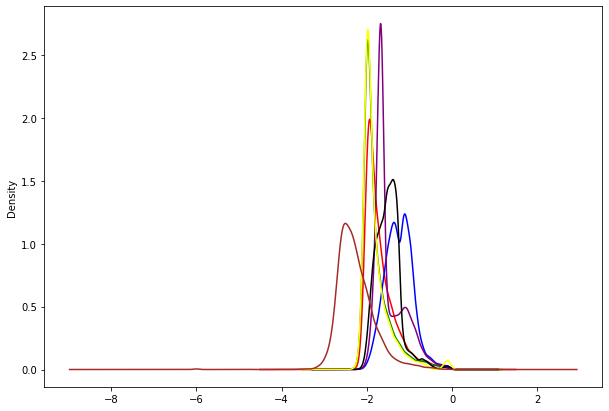

In [4]:
agg_dict = {'mean': 'mean', 
            'median': 'median', 
            'logmean': lambda x: np.exp(np.mean(np.log(x + eps))),
            'smartmean': smart_mean,
            'votemean': vote_mean,
            'votemedian': vote_median,
            'majority': majority,
            'minval': minval}
agg_res_external = {k: submissions_ext.groupby('image_name').agg(v) for k,v in agg_dict.items()}

fig, ax = plt.subplots(figsize=(10,7))
np.log10(agg_res_external['logmean'].target).plot.kde(ax=ax, color='red')
np.log10(agg_res_external['median'].target).plot.kde(ax=ax, color='green')
np.log10(agg_res_external['mean'].target).plot.kde(ax=ax, color='blue')
np.log10(agg_res_external['smartmean'].target).plot.kde(ax=ax, color='purple')
np.log10(agg_res_external['votemean'].target).plot.kde(ax=ax, color='black')
np.log10(agg_res_external['votemedian'].target).plot.kde(ax=ax, color='yellow')
np.log10(agg_res_external['minval']['target']+eps).plot.kde(ax=ax, color='brown')


print(agg_res_external['logmean'].target.mean(), sum(agg_res_external['logmean'].target>0.5))
print(agg_res_external['median'].target.mean(), sum(agg_res_external['median'].target>0.5))
print(agg_res_external['mean'].target.mean(), sum(agg_res_external['mean'].target>0.5))
print(agg_res_external['smartmean'].target.mean(), sum(agg_res_external['smartmean'].target>0.5))
print(agg_res_external['votemean'].target.mean(), sum(agg_res_external['votemean'].target>0.5))
print(agg_res_external['votemedian'].target.mean(), sum(agg_res_external['votemedian'].target>0.5))
print(agg_res_external['majority'].target.mean(), sum(agg_res_external['majority'].target>0.5))
print(agg_res_external['minval']['target'].mean(), sum(agg_res_external['minval']['target']>0.5))
print(agg_res_external['minval']['rank'].mean(), sum(agg_res_external['minval']['rank']>0.5))

agg_res_external['minval'][['rank']].to_csv("RESULTS/others_combined_minrank.csv", sep=",")

for k,v in agg_res_external.items():
    v[['target']].to_csv("RESULTS/others_combined_"+k+".csv", sep=",")

## Add the ANV-MEL

In [5]:
list_of_filenames = [str(_f) for _f in Path('ANV').glob('*.csv')]
list_of_submissions = [pd.read_csv(_f, dtype={'image_name':str, 
                                              'target':np.float64}, sep=',') for _f in list_of_filenames]
list_of_submissions = [df for df in list_of_submissions if (df.target.max()>0.65) & (df.target.min()<0.35)] 

anv_mel = pd.concat(list_of_submissions)
anv_mel = anv_mel.groupby('image_name')[['target']].agg(lambda x: np.exp(np.mean(np.log(x + eps))))

anv_mel.columns = ['target_anv']
anv_mel_combined = pd.DataFrame(agg_res_external['votemedian']).join(anv_mel)

# doubts
###########
anv_mel_combined.loc[(anv_mel_combined.target<0.5) & 
                     (anv_mel_combined.target>0.4) & 
                     (anv_mel_combined.target_anv>0.65),'target'] = \
1-anv_mel_combined.loc[(anv_mel_combined.target<0.5) & 
                     (anv_mel_combined.target>0.4) & 
                     (anv_mel_combined.target_anv>0.65),'target']

anv_mel_combined.loc[(anv_mel_combined.target>0.5) & 
                     (anv_mel_combined.target<0.6) & 
                     (anv_mel_combined.target_anv<0.4),'target'] = \
1-anv_mel_combined.loc[(anv_mel_combined.target>0.5) & 
                     (anv_mel_combined.target<0.6) & 
                     (anv_mel_combined.target_anv<0.4),'target']

anv_mel_combined[['target']].to_csv('RESULTS/anv_mel_corrected_doubts_external.csv', sep=',')

# certains
############
anv_mel_combined.loc[(anv_mel_combined.target>0.95) & 
                     (anv_mel_combined.target_anv<0.30), 'target'] = \
-0.5+anv_mel_combined.loc[(anv_mel_combined.target>0.95) & 
                     (anv_mel_combined.target_anv<0.30), 'target']

anv_mel_combined[['target']].to_csv('RESULTS/anv_mel_corrected_doubts_certainMel_external.csv', sep=',')

# certains
# In case of doubt about a negative, assume slightly positive
############
anv_mel_combined.loc[(anv_mel_combined.target<0.05) & 
                     (anv_mel_combined.target_anv>0.95), 'target'] = \
0.5+anv_mel_combined.loc[(anv_mel_combined.target<0.05) & 
                     (anv_mel_combined.target_anv>0.95), 'target']

anv_mel_combined[['target']].to_csv('RESULTS/anv_mel_corrected_doubts_certainMel_certainNonMel_external.csv', sep=',')
anv_mel_combined['rank_anv'] = anv_mel_combined['target_anv'].rank()
anv_mel_combined['rank_anv'] = anv_mel_combined['rank_anv']/anv_mel_combined['rank_anv'].max()
anv_mel_combined['rank_multi'] = anv_mel_combined['rank']*anv_mel_combined['rank_anv']

## Our predictions

In [6]:
#### collect the submission files 
list_of_filenames = [str(_f) for _f in Path('OUR_IMAGE_MODELS').glob('*.csv')]
list_of_submissions = [pd.read_csv(_f, dtype={'image_name':str, 
                                              'target':np.float64}, sep=',') for _f in list_of_filenames]
list_of_submissions = [df for df in list_of_submissions if (df.target.max()>0.65) & (df.target.min()<0.35)] 

# minmax normalise..
if minmax_normalise:
    submission_normalised = []
    for df in list_of_submissions:
        df_max = df.target.max()
        df_min = df.target.min()
        df.loc[df.target>0.5, 'target'] = df.loc[df.target>0.5].target/df_max
        df.loc[df.target<0.5, 'target'] = df.loc[df.target<0.5].target-df_min
        submission_normalised.append(df)
        submissions_ours = pd.concat(submission_normalised, axis=0)
else:
    submissions_ours = pd.concat(list_of_submissions, axis=0)
    
submissions_ours['rank'] = submissions_ours.target.rank()
submissions_ours['rank'] = submissions_ours['rank']/submissions_ours['rank'].max()

/home/bramiozo/VIRTUALENVS/torch_image/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


0.026482817672956415 47
0.028512111584089252 69
0.032844319111722114 69
0.03042263456098229 75
0.0316813150998619 72
0.03160961011627445 151
0.02080677472227281 152
0.009621831913959107 5
0.1959067991432712 1185


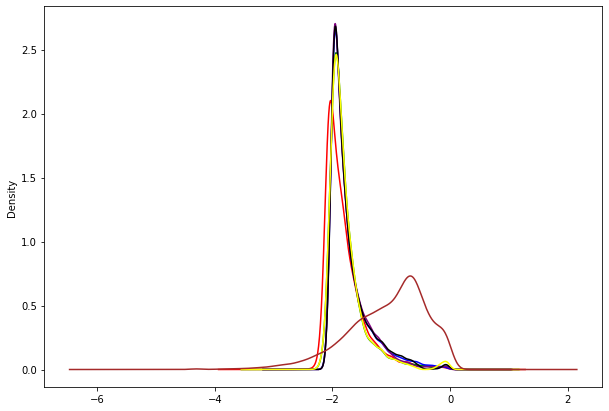

In [7]:
agg_dict = {'mean': 'mean', 
            'median': 'median', 
            'logmean': lambda x: np.exp(np.mean(np.log(x + eps))),
            'smartmean': smart_mean,
            'votemean': vote_mean,
            'votemedian': vote_median,
            'majority': majority,
            'minval': minval}
agg_res_ours = {k: submissions_ours.groupby('image_name').agg(v) for k,v in agg_dict.items()}

fig, ax = plt.subplots(figsize=(10,7))
np.log10(agg_res_ours['logmean'].target).plot.kde(ax=ax, color='red')
np.log10(agg_res_ours['median'].target).plot.kde(ax=ax, color='green')
np.log10(agg_res_ours['mean'].target).plot.kde(ax=ax, color='blue')
np.log10(agg_res_ours['smartmean'].target).plot.kde(ax=ax, color='purple')
np.log10(agg_res_ours['votemean'].target).plot.kde(ax=ax, color='black')
np.log10(agg_res_ours['votemedian'].target).plot.kde(ax=ax, color='yellow')
np.log10(agg_res_ours['minval']['rank']+eps).plot.kde(ax=ax, color='brown')


print(agg_res_ours['logmean'].target.mean(), sum(agg_res_ours['logmean'].target>0.5))
print(agg_res_ours['median'].target.mean(), sum(agg_res_ours['median'].target>0.5))
print(agg_res_ours['mean'].target.mean(), sum(agg_res_ours['mean'].target>0.5))
print(agg_res_ours['smartmean'].target.mean(), sum(agg_res_ours['smartmean'].target>0.5))
print(agg_res_ours['votemean'].target.mean(), sum(agg_res_ours['votemean'].target>0.5))
print(agg_res_ours['votemedian'].target.mean(), sum(agg_res_ours['votemedian'].target>0.5))
print(agg_res_ours['majority'].target.mean(), sum(agg_res_ours['majority'].target>0.5))
print(agg_res_ours['minval']['target'].mean(), sum(agg_res_ours['minval']['target']>0.5))
print(agg_res_ours['minval']['rank'].mean(), sum(agg_res_ours['minval']['rank']>0.5))

agg_res_ours['minval'][['rank']].to_csv("RESULTS/ours_minrank.csv", sep=",", header=['target'])

for k,v in agg_res_ours.items():
    v[['target']].to_csv("RESULTS/ours_"+k+".csv", sep=",")

## ANV-MEL correction on ours

In [35]:
anv_mel_combined = pd.DataFrame(agg_res_ours['votemedian']).join(anv_mel)

# doubts
###########
anv_mel_combined.loc[(anv_mel_combined.target<0.5) & 
                     (anv_mel_combined.target>0.4) & 
                     (anv_mel_combined.target_anv>0.65),'target'] = \
1-anv_mel_combined.loc[(anv_mel_combined.target<0.5) & 
                     (anv_mel_combined.target>0.4) & 
                     (anv_mel_combined.target_anv>0.65),'target']

anv_mel_combined.loc[(anv_mel_combined.target>0.5) & 
                     (anv_mel_combined.target<0.6) & 
                     (anv_mel_combined.target_anv<0.4),'target'] = \
1-anv_mel_combined.loc[(anv_mel_combined.target>0.5) & 
                     (anv_mel_combined.target<0.6) & 
                     (anv_mel_combined.target_anv<0.4),'target']

anv_mel_combined[['target']].to_csv('RESULTS/anv_mel_corrected_doubts_ours.csv', sep=',')
print((anv_mel_combined[['target']]>0.5).sum())

# certains
############
anv_mel_combined.loc[(anv_mel_combined.target>0.95) & 
                     (anv_mel_combined.target_anv<0.30), 'target'] = \
-0.5+anv_mel_combined.loc[(anv_mel_combined.target>0.95) & 
                     (anv_mel_combined.target_anv<0.30), 'target']

anv_mel_combined[['target']].to_csv('RESULTS/anv_mel_corrected_doubts_certainMel_ours.csv', sep=',')
print((anv_mel_combined[['target']]>0.5).sum())

# certains
# In case of doubt about a negative, assume slightly positive
############
anv_mel_combined.loc[(anv_mel_combined.target<0.05) & 
                     (anv_mel_combined.target_anv>0.95), 'target'] = \
0.5+anv_mel_combined.loc[(anv_mel_combined.target<0.05) & 
                     (anv_mel_combined.target_anv>0.95), 'target']

anv_mel_combined[['target']].to_csv('RESULTS/anv_mel_corrected_doubts_certainMel_certainNonMel_ours.csv', sep=',')
anv_mel_combined['rank_anv'] = anv_mel_combined['target_anv'].rank()
anv_mel_combined['rank_anv'] = anv_mel_combined['rank_anv']/anv_mel_combined['rank_anv'].max()
anv_mel_combined['rank_multi'] = anv_mel_combined['rank']*anv_mel_combined['rank_anv']
print((anv_mel_combined[['target']]>0.5).sum())

target    146
dtype: int64
target    142
dtype: int64
target    155
dtype: int64


## XGB Predictions


In [9]:
#### collect the submission files 
list_of_filenames = [str(_f) for _f in Path('OUR_XGB_STUFF').glob('*.csv')]
list_of_submissions = [pd.read_csv(_f, dtype={'image_name':str, 
                                              'target':np.float64}, sep=',') for _f in list_of_filenames]
list_of_submissions = [df for df in list_of_submissions if (df.target.max()>0.65) & (df.target.min()<0.35)] 

# minmax normalise..
if minmax_normalise:
    submission_normalised = []
    for df in list_of_submissions:
        df_max = df.target.max()
        df_min = df.target.min()
        df.loc[df.target>0.5, 'target'] = df.loc[df.target>0.5].target/df_max
        df.loc[df.target<0.5, 'target'] = df.loc[df.target<0.5].target-df_min
        submission_normalised.append(df)
        submissions_xgb = pd.concat(submission_normalised, axis=0)
else:
    submissions_xgb = pd.concat(list_of_submissions, axis=0)
    
submissions_xgb['rank'] = submissions_xgb.target.rank()
submissions_xgb['rank'] = submissions_xgb['rank']/submissions_xgb['rank'].max()

/home/bramiozo/VIRTUALENVS/torch_image/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


0.017143870454985943 110
0.034427429808185195 267
0.0666894364013601 233
0.050417665138384686 207
0.046672496991120804 267
0.04060954630264515 474
0.08830151818678499 474
0.004477804816439383 31
0.1645111781992425 810


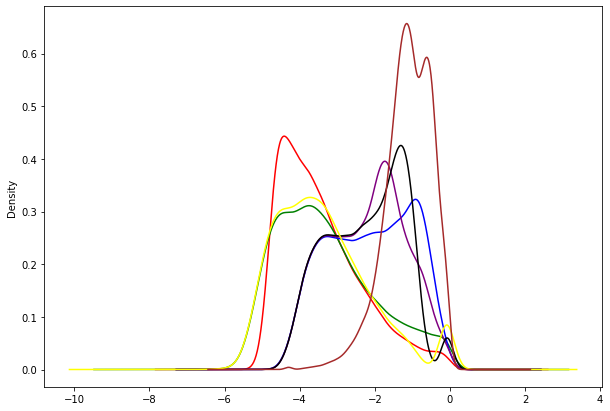

In [10]:
agg_dict = {'mean': 'mean', 
            'median': 'median', 
            'logmean': lambda x: np.exp(np.mean(np.log(x + eps))),
            'smartmean': smart_mean,
            'votemean': vote_mean,
            'votemedian': vote_median,
            'majority': majority,
            'minval': minval}
agg_res_xgb = {k: submissions_xgb.groupby('image_name').agg(v) for k,v in agg_dict.items()}

fig, ax = plt.subplots(figsize=(10,7))
np.log10(agg_res_xgb['logmean'].target).plot.kde(ax=ax, color='red')
np.log10(agg_res_xgb['median'].target).plot.kde(ax=ax, color='green')
np.log10(agg_res_xgb['mean'].target).plot.kde(ax=ax, color='blue')
np.log10(agg_res_xgb['smartmean'].target).plot.kde(ax=ax, color='purple')
np.log10(agg_res_xgb['votemean'].target).plot.kde(ax=ax, color='black')
np.log10(agg_res_xgb['votemedian'].target).plot.kde(ax=ax, color='yellow')
np.log10(agg_res_xgb['minval']['rank']+eps).plot.kde(ax=ax, color='brown')


print(agg_res_xgb['logmean'].target.mean(), sum(agg_res_xgb['logmean'].target>0.5))
print(agg_res_xgb['median'].target.mean(), sum(agg_res_xgb['median'].target>0.5))
print(agg_res_xgb['mean'].target.mean(), sum(agg_res_xgb['mean'].target>0.5))
print(agg_res_xgb['smartmean'].target.mean(), sum(agg_res_xgb['smartmean'].target>0.5))
print(agg_res_xgb['votemean'].target.mean(), sum(agg_res_xgb['votemean'].target>0.5))
print(agg_res_xgb['votemedian'].target.mean(), sum(agg_res_xgb['votemedian'].target>0.5))
print(agg_res_xgb['majority'].target.mean(), sum(agg_res_xgb['majority'].target>0.5))
print(agg_res_xgb['minval']['target'].mean(), sum(agg_res_xgb['minval']['target']>0.5))
print(agg_res_xgb['minval']['rank'].mean(), sum(agg_res_xgb['minval']['rank']>0.5))

agg_res_xgb['minval'][['rank']].to_csv("RESULTS/ours_minrank.csv", sep=",", header=['target'])

for k,v in agg_res_xgb.items():
    v[['target']].to_csv("RESULTS/xgb_"+k+".csv", sep=",")

## threshold value matching

In [11]:
ext = agg_res_external['votemedian'].copy()
ext.drop(['target', 'rank'], axis=1, inplace=True)
ext['ext_num_05'] = (agg_res_external['votemedian'].target>0.5).astype(int)
ext['ext_num_065'] = (agg_res_external['votemedian'].target>0.65).astype(int)
ext['ext_num_075'] = (agg_res_external['votemedian'].target>0.75).astype(int)
ext['ext_num_085'] = (agg_res_external['votemedian'].target>0.85).astype(int)

ours = agg_res_ours['votemedian'].copy()
ours.drop(['target', 'rank'], axis=1, inplace=True)
ours['ours_num_05'] = (agg_res_ours['votemedian'].target>0.5).astype(int)
ours['ours_num_065'] = (agg_res_ours['votemedian'].target>0.65).astype(int)
ours['ours_num_075'] = (agg_res_ours['votemedian'].target>0.75).astype(int)
ours['ours_num_085'] = (agg_res_ours['votemedian'].target>0.85).astype(int)

In [12]:
joined = ext.join(ours)
joined.corr()

,ext_num_05,ext_num_065,ext_num_075,ext_num_085,ours_num_05,ours_num_065,ours_num_075,ours_num_085
ext_num_05,1.000000,0.926352,0.787921,0.482789,0.644491,0.615849,0.603495,0.500765
ext_num_065,0.926352,1.000000,0.850563,0.521172,0.575827,0.557645,0.563549,0.469202
ext_num_075,0.787921,0.850563,1.000000,0.612737,0.479369,0.467830,0.467070,0.426511
ext_num_085,0.482789,0.521172,0.612737,1.000000,0.290009,0.286507,0.330406,0.336074
ours_num_05,0.644491,0.575827,0.479369,0.290009,1.000000,0.919721,0.799498,0.589785
ours_num_065,0.615849,0.557645,0.467830,0.286507,0.919721,1.000000,0.869284,0.641265
ours_num_075,0.603495,0.563549,0.467070,0.330406,0.799498,0.869284,1.000000,0.737694
ours_num_085,0.500765,0.469202,0.426511,0.336074,0.589785,0.641265,0.737694,1.000000


## Weakly supervised

Pull in **all** individual predictions

In [13]:
# lf: > threshold_plus = 1,  threshold_min < 1< threshold_plus = -1, < threshold_min = 0
import snorkel
from snorkel.labeling.model import LabelModel
from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier

In [14]:
external_file_list =  [str(_f) for _f in Path('OTHERS').glob('submission*.csv')]
our_file_list = [str(_f) for _f in Path('OUR_IMAGE_MODELS').glob('*.csv')]
xgboost_file_list = [str(_f) for _f in Path('OUR_XGB_STUFF').glob('*.csv')]
anv_file_list = [str(_f) for _f in Path('ANV').glob('*.csv')]


list_of_filenames=our_file_list 
list_of_filenames+=xgboost_file_list
list_of_filenames+=external_file_list
#list_of_filenames+=anv_file_list

dict_of_submissions = {_f.split("/")[-1]: pd.read_csv(_f, dtype={'image_name':str, 
                                              'target':np.float64}, sep=',') for _f in list_of_filenames}
list_of_submissions=list(dict_of_submissions.values())

## First  get aggregation over all predictions

In [15]:
# minmax normalise..
if minmax_normalise:
    submission_normalised = []
    for df in list_of_submissions:
        df_max = df.target.max()
        df_min = df.target.min()
        df.loc[df.target>0.5, 'target'] = df.loc[df.target>0.5].target/df_max
        df.loc[df.target<0.5, 'target'] = df.loc[df.target<0.5].target-df_min
                
        if (df.target.min()>=0) & (df.target.max()<=1):
            submission_normalised.append(df)
            submissions_all = pd.concat(submission_normalised, axis=0)
else:
    submissions_all = pd.concat(list_of_submissions, axis=0)
    
submissions_all['rank'] = submissions_all.target.rank()
submissions_all['rank'] = submissions_all['rank']/submissions_all['rank'].max()

0.013853303122569854 4
0.01766686082867209 12
0.03665557793080427 27
0.02871603959720389 32
0.024874102316885097 12
0.01940931972556831 69
0.0343314312309031 69
0.0005067704439578839 0
0.03825389804979539 149


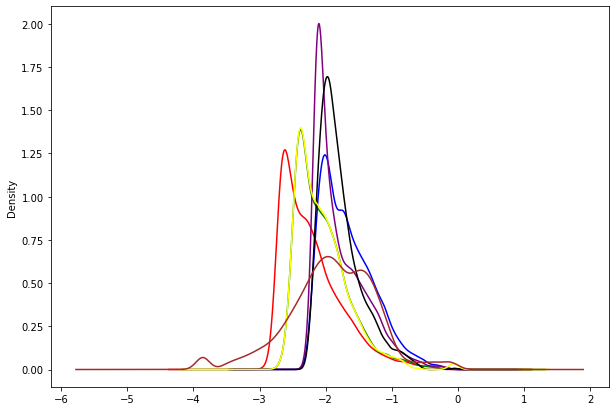

In [16]:
agg_dict = {'mean': 'mean', 
            'median': 'median', 
            'logmean': lambda x: np.exp(np.mean(np.log(x + eps))),
            'smartmean': smart_mean,
            'votemean': vote_mean,
            'votemedian': vote_median,
            'majority': majority,
            'minval': minval}
agg_res_all = {k: submissions_all.groupby('image_name').agg(v) for k,v in agg_dict.items()}

fig, ax = plt.subplots(figsize=(10,7))
np.log10(agg_res_all['logmean'].target).plot.kde(ax=ax, color='red')
np.log10(agg_res_all['median'].target).plot.kde(ax=ax, color='green')
np.log10(agg_res_all['mean'].target).plot.kde(ax=ax, color='blue')
np.log10(agg_res_all['smartmean'].target).plot.kde(ax=ax, color='purple')
np.log10(agg_res_all['votemean'].target).plot.kde(ax=ax, color='black')
np.log10(agg_res_all['votemedian'].target).plot.kde(ax=ax, color='yellow')
np.log10(agg_res_all['minval']['rank']+eps).plot.kde(ax=ax, color='brown')


print(agg_res_all['logmean'].target.mean(), sum(agg_res_all['logmean'].target>0.5))
print(agg_res_all['median'].target.mean(), sum(agg_res_all['median'].target>0.5))
print(agg_res_all['mean'].target.mean(), sum(agg_res_all['mean'].target>0.5))
print(agg_res_all['smartmean'].target.mean(), sum(agg_res_all['smartmean'].target>0.5))
print(agg_res_all['votemean'].target.mean(), sum(agg_res_all['votemean'].target>0.5))
print(agg_res_all['votemedian'].target.mean(), sum(agg_res_all['votemedian'].target>0.5))
print(agg_res_all['majority'].target.mean(), sum(agg_res_all['majority'].target>0.5))
print(agg_res_all['minval']['target'].mean(), sum(agg_res_all['minval']['target']>0.5))
print(agg_res_all['minval']['rank'].mean(), sum(agg_res_all['minval']['rank']>0.5))

agg_res_all['minval'][['rank']].to_csv("RESULTS/all_minrank.csv", sep=",", header=['target'])

for k,v in agg_res_all.items():
    v[['target']].to_csv("RESULTS/all_"+k+".csv", sep=",")

In [17]:
ign=[]
cleaned_sub_dict = {}
if minmax_normalise:
    for k, v in dict_of_submissions.items():
        v.set_index('image_name', inplace=True)
        df_max = v.target.max()
        df_min = v.target.min()
        v.loc[v.target>0.5, 'target'] = v.loc[v.target>0.5].target/df_max
        v.loc[v.target<0.5, 'target'] = v.loc[v.target<0.5].target-df_min
        dict_of_submissions[k] = v        
        
        #if (v.target.min()<0) | (v.target.mean()>0.12) | (v.target.max()>1):
        #    ign.append(k)
    for _k in dict_of_submissions.keys():
        if _k not in ign:
            cleaned_sub_dict[_k] = dict_of_submissions[_k]
del dict_of_submissions
dict_of_submissions = cleaned_sub_dict

In [18]:
for idx, (k,v) in enumerate(dict_of_submissions.items()):
    v.rename(index=str, columns={'target': 'target_'+str(idx)}, inplace=True)
    if idx==0:
        fin = v[['target_0']]
    else:        
        fin = fin.join(v[['target_'+str(idx)]])
        
def get_target_from_proba(x, thres_plus=0.65, thres_min=0.35):
    xv = x.values
    xv[:]=-1
    xv[(x>thres_plus).values]=1
    xv[(x<thres_min).values]=0
    return x

In [19]:
from sklearn.impute import SimpleImputer
simp = SimpleImputer(strategy='mean')
fin.loc[:,:] = simp.fit_transform(fin)

In [20]:
thresh_plus = 0.90
thresh_min = 0.25
fin_lf = fin.copy()
try:
    fin.drop('target', axis=1, inplace=True)
except:
    pass
for idx, _c in enumerate(fin.columns):
    fin_lf.loc[fin[_c]>thresh_plus, _c] = 1
    fin_lf.loc[fin[_c]<thresh_min,_c] = 0
    fin_lf.loc[((fin[_c]>=thresh_min) & (fin[_c]<=thresh_plus)), _c] = -1
fin_lf = fin_lf.astype(int)

In [21]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(fin_lf.values, n_epochs=2500, log_freq=50, seed=123, lr=0.005)
wlpred = label_model.predict_proba(L=fin_lf)
fin['target']=wlpred[:,1]

In [22]:
_sum = sum(fin.target>0.5)

In [23]:
fin[['target']].to_csv('RESULTS/snorkel'+str(_sum)+'.csv',sep=",")

## Analysis

In [24]:
aggt = 'minval'
votemedian_ALL_res = agg_res_all[aggt][['rank']].rename(index=str, columns={'rank':'target'})
votemedian_OURS_res = agg_res_ours[aggt][['rank']].rename(index=str, columns={'rank':'target'})
votemedian_XGB_res = agg_res_xgb[aggt][['rank']].rename(index=str, columns={'rank':'target'})
votemedian_EXT_res = agg_res_external[aggt][['rank']].rename(index=str, columns={'rank':'target'})

# exclusive selection
list_df = [votemedian_OURS_res, votemedian_XGB_res, votemedian_EXT_res]
#list_df = list(agg_res_ours.values())
#list_df += list(agg_res_xgb.values())
#list_df += list(agg_res_external.values())
#list_df += list(agg_res_all.values())


In [25]:
positive_union = set([t[0] for df in list_df for t in df.itertuples() if t[1]>0.5])
negative_union = set([t[0] for df in list_df for t in df.itertuples() if t[1]<0.5])

In [26]:
# credits: https://stackoverflow.com/questions/3852780/python-intersection-of-multiple-lists
def intersect(d):
    sets = iter(map(set, d))
    result = next(sets)
    for s in sets:
        result = result.intersection(s)
    return result

list_of_list = []
for df in list_df:
    list_of_list.append([t[0] for t in df.itertuples() if t[1]>0.5])
positive_intersection = intersect(list_of_list)

for df in list_df:
    list_of_list.append([t[0] for t in df.itertuples() if t[1]<0.5])
negative_intersection = intersect(list_of_list)

In [27]:
len(positive_union), len(positive_intersection)

(2151, 403)

In [28]:
set_all_minrank = set(agg_res_all['minval'][agg_res_all['minval']['rank']>0.5].index)

In [29]:
len(set_all_minrank), len(positive_intersection.union(set_all_minrank))

(149, 410)

In [30]:
# stack
stacked_intersect = pd.concat(list_df)
stacked_intersect = stacked_intersect.loc[list(positive_intersection)]
stacked_intersect.reset_index(inplace=True)
stacked_intersect = stacked_intersect.groupby('image_name').mean()

stacked_positive_union= pd.concat(list_df)
stacked_positive_union = stacked_positive_union.loc[list(positive_union)]
stacked_positive_union.reset_index(inplace=True)
stacked_positive_union = stacked_positive_union.groupby('image_name').max()

# now we need to stack it with other predictions
stacked_negative_union= pd.concat(list_df)
stacked_negative_union = stacked_negative_union.loc[list(negative_union)]
stacked_negative_union.reset_index(inplace=True)
stacked_negative_union = stacked_negative_union.groupby('image_name').min()

stacked_intersect_final = pd.concat([stacked_intersect, stacked_negative_union])

In [31]:
stacked_union_final = pd.concat([stacked_positive_union, stacked_negative_union])
stacked_union_final.reset_index(inplace=True)
stacked_union_final = stacked_union_final.groupby('image_name').mean()

In [32]:
stacked_intersect_final.to_csv("RESULTS/stacked_best_intersect.csv", sep=",")
stacked_union_final.to_csv("RESULTS/stacked_best_union.csv", sep=",")

## Overlap

In [33]:
ours_set = set(agg_res_ours['votemedian'].index[agg_res_ours['votemedian'].target>0.5])
xgb_set = set(agg_res_xgb['votemedian'].index[agg_res_xgb['votemedian'].target>0.5])
overlap = ours_set.union(xgb_set)
in_ours_not_in_xgb = ours_set-xgb_set
in_xgb_not_in_ours = xgb_set-ours_set

len(ours_set), len(xgb_set), len(overlap), len(in_ours_not_in_xgb), len(in_xgb_not_in_ours)

(151, 474, 520, 46, 369)

In [34]:
anv_corr_set = set(anv_mel_combined.index[anv_mel_combined.target>0.5])

## Merge with patient data